In [27]:
%run 00_config_and_utils.ipynb

import cvxpy as cvx
from sklearn.covariance import LedoitWolf
import statsmodels.api as sm

ret = pd.read_parquet("../data/processed/ret.parquet")
spy_ret = pd.read_parquet("../data/processed/spy_ret.parquet")["SPY"]
beta = pd.read_parquet("../data/processed/beta.parquet")
signals_p = pd.read_parquet("../data/processed/signals_purified.parquet")

ret.shape, spy_ret.shape, beta.shape, signals_p.shape

((2512, 50), (2512,), (2512, 50), (2512, 150))

In [28]:
# adds 0 to return a numpy array of NxN cov matrix aligned to the column order of the returns window
def ledoit_wolf_cov(returns_window: pd.DataFrame):
    X = returns_window.fillna(0.0).values
    return LedoitWolf().fit(X).covariance_

# maximise alpha and penalize risk and turnover
def solve_portfolio(alpha: pd.Series,
                    sigma: np.ndarray,
                    w_prev: pd.Series,
                    beta_vec: pd.Series | None = None):
    tickers = alpha.index
    n = len(tickers)

    w = cvx.Variable(n)
    Sigma = cvx.Parameter((n, n), PSD=True, value=sigma)

    obj = cvx.Minimize(
        -alpha.values @ w
        + CONFIG["lam_risk"] * cvx.quad_form(w, Sigma)
        + CONFIG["gamma_turnover"] * cvx.norm1(w - w_prev.values)
    )

    constraints = [
        cvx.sum(w) == 0,
        cvx.norm1(w) <= CONFIG["gross_leverage"],
        w <= CONFIG["pos_cap"],
        w >= -CONFIG["pos_cap"],
    ]

    if beta_vec is not None:
        constraints.append(beta_vec.values @ w == 0)

    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.OSQP)

    if w.value is None:
        return None

    return pd.Series(w.value, index=tickers)

In [29]:
# rebalance
reb_dates = make_rebalance_dates(ret.index, CONFIG["rebalance_rule"])

portfolio_rets = []
turnover_rows = []
cost_rows = []
weights_hist = {}

w_prev_full = pd.Series(0.0, index=ret.columns)
tcost = CONFIG["tcost_bps"] / 1e4

reb_dates[:5], reb_dates[-5:]

(DatetimeIndex(['2016-01-08', '2016-01-15', '2016-01-22', '2016-01-29',
                '2016-02-05'],
               dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex(['2025-11-28', '2025-12-05', '2025-12-12', '2025-12-19',
                '2025-12-26'],
               dtype='datetime64[ns]', name='Date', freq=None))

In [30]:
#backtest
# each loop handles one holding peroid(1 week ish)
# extract each signals cross-sectional on date t(mom, rev, vol)
# use ledoit_wolf_cov() to return a NxN cov matrix

for i in range(len(reb_dates) - 1):
    t = reb_dates[i]
    t_next = reb_dates[i + 1]

    if t not in signals_p.index or t not in beta.index:
        continue

    mom_t = signals_p.loc[t, ("mom", slice(None))].droplevel(0)
    rev_t = signals_p.loc[t, ("rev", slice(None))].droplevel(0)
    lowv_t = signals_p.loc[t, ("lowvol", slice(None))].droplevel(0)

    alpha = (mom_t + rev_t + lowv_t) / 3.0
    alpha = alpha.dropna()

    if len(alpha) < 20:
        continue

    beta_vec = beta.loc[t, alpha.index].dropna()
    alpha = alpha.loc[beta_vec.index]

    if len(alpha) < 20:
        continue

    ret_win = ret.loc[:t].tail(CONFIG["lookback_cov"])[alpha.index]

    if ret_win.shape[0] < CONFIG["lookback_cov"] * 0.8:
        continue

    sigma = ledoit_wolf_cov(ret_win)

    w_prev = w_prev_full.reindex(alpha.index).fillna(0.0)
    w_new = solve_portfolio(alpha, sigma, w_prev, beta_vec=beta_vec)

    if w_new is None:
        continue

    turnover = (w_new - w_prev).abs().sum()
    cost = tcost * turnover

    period_rets = ret.loc[t:t_next, alpha.index].iloc[1:]
    daily_port = period_rets @ w_new

    if len(daily_port) > 0:
        daily_port.iloc[0] -= cost

    portfolio_rets.append(daily_port)

    turnover_rows.append({"date": t, "turnover": turnover})
    cost_rows.append({"date": t, "cost": cost})
    weights_hist[t] = w_new

    w_prev_full.loc[w_new.index] = w_new

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/wangzhenghua/jenv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:242: UserWarning: You are solving a parameterized prob

In [31]:
port_ret = pd.concat(portfolio_rets).sort_index()

turnover_df = pd.DataFrame(turnover_rows).set_index("date").sort_index()
cost_df = pd.DataFrame(cost_rows).set_index("date").sort_index()

port_ret.head(), port_ret.tail(), turnover_df.shape, cost_df.shape

(Date
 2017-01-09   -0.000335
 2017-01-10   -0.000022
 2017-01-11    0.000113
 2017-01-12   -0.000043
 2017-01-13   -0.000716
 dtype: float64,
 Date
 2025-12-19    0.001394
 2025-12-22    0.001569
 2025-12-23    0.002595
 2025-12-24   -0.000382
 2025-12-26   -0.000897
 dtype: float64,
 (454, 1),
 (454, 1))

In [32]:
# equity curve + drawdown
equity = (1 + port_ret.fillna(0.0)).cumprod()
mdd, dd_series = max_drawdown(equity)
stats = annualized_stats(port_ret)

stats, mdd

({'ann_return': 0.02411438878837214,
  'ann_vol': 0.036890017057882016,
  'sharpe': 0.6536833190002496},
 -0.08486587553459246)

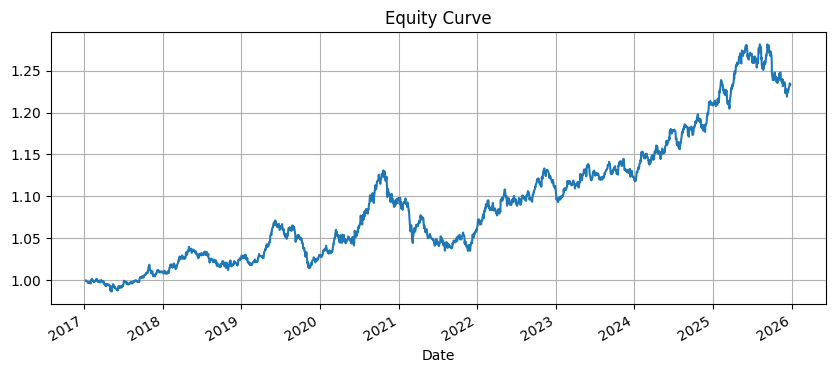

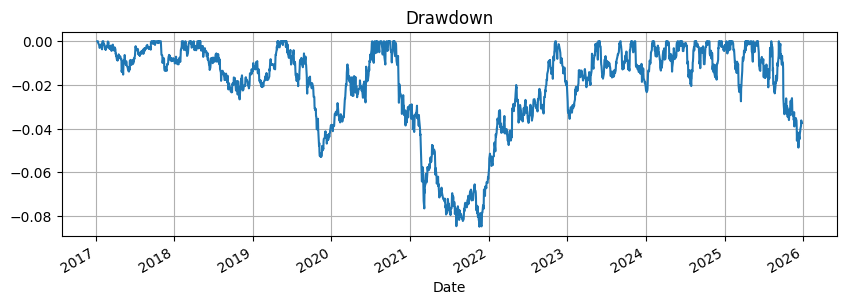

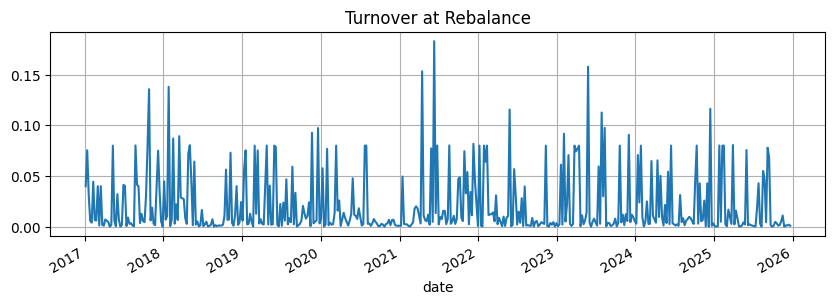

In [33]:
# plot equity, drawdown, turnover
plt.figure(figsize=(10,4))
equity.plot()
plt.grid(True)
plt.title("Equity Curve")
plt.show()

plt.figure(figsize=(10,3))
dd_series.plot()
plt.grid(True)
plt.title("Drawdown")
plt.show()

plt.figure(figsize=(10,3))
turnover_df["turnover"].plot()
plt.grid(True)
plt.title("Turnover at Rebalance")
plt.show()

In [34]:
# strat beta/a;pha regression vs spy
common = port_ret.index.intersection(spy_ret.index)

y = port_ret.loc[common]
x = spy_ret.loc[common]

X = sm.add_constant(x)
res = sm.OLS(y, X, missing="drop").fit()

res.params, res.tvalues, res.rsquared

(const    0.000101
 SPY     -0.008912
 dtype: float64,
 const    2.067881
 SPY     -2.124015
 dtype: float64,
 0.00199841311007809)

In [35]:
# save outputs
equity.to_csv("outputs/results/equity_curve.csv")
port_ret.to_csv("outputs/results/portfolio_returns.csv")
turnover_df.to_csv("outputs/results/turnover.csv")
cost_df.to_csv("outputs/results/costs.csv")

w_df = pd.DataFrame(weights_hist).T.sort_index()
w_df.to_parquet("outputs/results/weights.parquet")

stats_out = {
    "ann_return": float(stats["ann_return"]),
    "ann_vol": float(stats["ann_vol"]),
    "sharpe": float(stats["sharpe"]),
    "max_drawdown": float(mdd),
    "reg_alpha_daily": float(res.params["const"]),
    "reg_beta": float(res.params.iloc[1]),
    "reg_r2": float(res.rsquared),
}
pd.Series(stats_out).to_json("outputs/results/metrics.json")

stats_out

{'ann_return': 0.02411438878837214,
 'ann_vol': 0.036890017057882016,
 'sharpe': 0.6536833190002496,
 'max_drawdown': -0.08486587553459246,
 'reg_alpha_daily': 0.00010126201148373979,
 'reg_beta': -0.008911935937904703,
 'reg_r2': 0.00199841311007809}

In [36]:
# check if gross exposure is less than 1 and net should be zero as dollar enutral
gross = w_df.abs().sum(axis=1)
net = w_df.sum(axis=1)

gross.describe(), net.describe()

(count    454.000000
 mean       0.787366
 std        0.161405
 min        0.040001
 25%        0.794770
 50%        0.836620
 75%        0.877534
 max        0.915938
 dtype: float64,
 count    4.540000e+02
 mean    -7.552942e-10
 std      1.353170e-08
 min     -1.440023e-07
 25%     -3.695672e-09
 50%     -3.291008e-12
 75%      3.331310e-09
 max      5.143714e-08
 dtype: float64)